In [2]:
import cv2, json, shutil, re
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time, os,datetime
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

2023-06-21 09:53:12.501369: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 09:53:12.703439: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
class node:
    __version__='1.1.1'
    
    def __init__(self, w=1, b=0):
        self.w = np.array(w, np.float32)
        self.b = np.array(b, np.float32)
        
        self.prev_node = None
        self.next_node = None
        self.X = None
        
        self.w_history = [float(self.w)]
        self.b_history = [float(self.b)]
        
    def __call__(self, node):
        self.prev_node = node
        node.next_node = self
        return self
    
    def forward(self, X):
        self.X = X
        return self.w*x + self.b
    
    def grad(self, X=None):
        if X is None:
            X = self.X
            
        # 다음 layer(next_node)를 가져와 곱하는 코드(재귀형태: L1->L2->...)
        grad = self.next_node.grad()[0]  
        return (X*grad, 1*grad)
    
    def backward(self, grad=None, optimizer=None):
        if grad is None:
            grad = self.grad()
            
        # 자신의 grad호출 후 grad[0], grad[1] 할당
        # 이때, grad[0]은 weight, grad[1]은 bias
        self.w -= optimizer(self, np.mean(grad[0]))
        self.b -= optimizer(self, np.mean(grad[1]))
        
        self.w_history.append(float(self.w))
        self.b_history.append(float(self.b))

In [17]:
class optimizers:
    def __init__(self, name=None, learning_rate=None, **kwargs):
        if name == 'SGD':
            self.optimizer = SGD(learning_rate=0.01)
        if name == 'Adam':
            self.optimizer = Adam(learning_rate=0.001)      

![nn](./optimizer.png)

In [20]:
class SGD(optimizers):
    def __init__(self, 
                learning_rate=0.01, momentum=0.0, epsilon=1e-7,
                 weight_decay=None, name="SGD", **kwargs):
        
        super().__init__(name=name, learning_rate=learning_rate)
        self.momentum = momentum
        self.weight_decay = weight_decay
        
        self.v = {}
        
    def __call__(self, node, grad):
        if not node in self.v:
            self.v[node] = grad
        
        else:
            self.v[node] = learning_rate*self.v[node] - self.epsilon*grad
        
        return self.v[node]
        
        
        
        
        

class Adam(optimizers):
    def __init__(self, 
                learning_rate=0.001,
                beta_1=0.9, beta_2=0.999, epsilon=1e-7,
                weight_decay=None, name="Adam", **kwargs):
        
        super().__init__(name=name, learning_rate=learning_rate)
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        
        # gradient값 저장
        self.m = {}  # gradient의 지수이동평균
        self.v = {}  # gradient제곱의 지수이동평균
        
    def __call__(self, node, grad):
        if not node in self.m:
            self.m[node] = grad
            
        else:
            self.m[node] = self.beta_1*self.m[node] + (1-self.beta_1)*grad
        
        if not node in self.v:
            self.v[node] = grad**2
            
        else:
            self.v[node] = self.beta_2*self.v[node] + (1-self.beta_2)*grad**2
            
        m_hat = self.m[node] / (1-self.beta_1)
        v_hat = self.v[node] / (1-self.beta_2)
        
        update = self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
        
        return update

In [27]:
class Activation:
    def __init__(self):
        self.prev_node = None
        self.next_node = None
        self.X = None

In [ ]:
class ReLU(Activation):
    def __init__(self):
        super().__init__()
    
    def __call__(self, node):
        self.prev_node = node
        self.next_node = self
        return self
    
    def forward(self, X):
        self.X = X
        return (self.X > 0).astype(np.float32) * X
    
    def grad(self, X=None):
        if X is None:
            X = self.X
        
        grad = self.next_node.grad()[0]
        return ((self.X > 0).astype(np.float32)*grad, )
    
    def backward(self, grad=None, optimizer=None):
        pass
    

    
# 수치적 안정화된 softmax는 극도록 크거나 작은 양수, 음수에도 수치오차가 작다.
# 따라서 softmax는 수치적 안정화가 필요하다: softmax(z) = softmax(z - max(z_i))

# z = x - max(x)
# softmax = np.exp(z) / np.sum(np.exp(z))

class softmax(Activation):
    def __init_(self):
        super().__init__()
        
    def __call_(self, node):
        self.prev_node = node
        self.next_node = self
        return self
    
    def forward(self, X):
        self.X = X
        z = self.X - np.max(X, axis=1, keepdims=True)
        exp_values = np.exp(z)
        softmax_values = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        return softmax_values
    
    
    def grad(self, grad=None):
        if grad is None:
            grad = self.next_node.grad()
        
        softmax_grad = self.softmax_values * grad
        sum_softmax_grad = np.sum(softmax_grad, axis=1, keepdims=True)
        return softmax_grad - self.softmax_values * sum_softmax_grad
    
        
    def backward(self, grad=None, optimizer=None):
        pass

In [88]:
class CCE_Loss:
    def __init__(self):
        self.previous_node=None
        self.Y=None
        self.P=None
        self.n=None
    
    def __call__(self,node):  
        self.previous_node=node
        node.next_node=self
        return self
        
    def compute_loss(self, Y, P):  # forward역할, 가장 마지막 층이기에 backward함수 필요X
        self.Y=Y   # truth
        self.P=P   # predict
        self.n=len(Y)
        
        epsilon = 1e-7
        
        P = np.clip(P, epsilon, 1-epsilon)  # P를 0~1로 제한

        # 정답라벨 on-hot encoding
        if len(Y.shape) == 1:
            Y = np.eye(P.shape[1])[Y]  
        
        self.loss= -np.sum(Y * np.log(P)) / P.shape[0]
        return self.loss

    def gradients(self):
        P=self.P
        Y=self.Y
        return (-((Y-P)/np.maximum(np.abs(Y-P),1e-13))/self.n,)


In [30]:
# 앞선 torch와 달리 tensorflow방식으로 구현
class Model:
    def __init__(self,inputs,outputs):
        self.inputs=inputs
        self.outputs=outputs
        
    def __call__(self,X):
        out=X
        this_layer=self.inputs
        
        # output layer전까지 L1-> L2-> L3순으로 feedforward진행
        # output을 못만나면 tensorflow의 경우, does not exits gradient오류가 발생.
        while id(this_layer)!=id(self.outputs):  
            out=this_layer.forward(out)
            this_layer=this_layer.next_node
        out=self.outputs.forward(out)
        return out
    
    
    def set_loss(self,loss_func):  # loss_func 클래스와 outputs를 연결
        self.loss_func=loss_func()(self.outputs)
        
        
    def set_optimizer(self,optimizer):
        self.optimizer=optimizer
        
        
    def compute_loss(self, Y, P):   # Loss값 계산
        return self.loss_func.compute_loss(Y,P)
    
    
    def backward(self):
        out=X
        this_layer=self.inputs
        while id(this_layer)!=id(self.outputs):
            this_layer.backward(optimizer=self.optimizer)
            this_layer=this_layer.next_node
        self.outputs.backward(optimizer=self.optimizer)

In [72]:
out=node()

In [80]:
#inputs=node()
#outputs=ReLU()(inputs)
#outputs=node()(outputs)

In [73]:
model=Model(out,out)

In [74]:
model.set_loss(MSE_Loss)

In [81]:
model.set_optimizer(Adam(1e-2))

In [82]:
for i in range(10000):
    P=model(X)
    model.compute_loss(Y,P)
    model.backward()
print(P)

[-5.71570650e-04  1.99870364e+00  3.99797884e+00  5.99725405e+00
  7.99652926e+00  9.99580447e+00  1.19950797e+01  1.39943549e+01
  1.59936301e+01  1.79929053e+01]


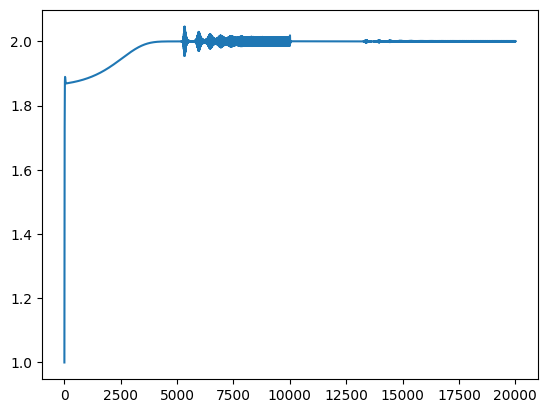

In [83]:
plt.plot(out.w_history)

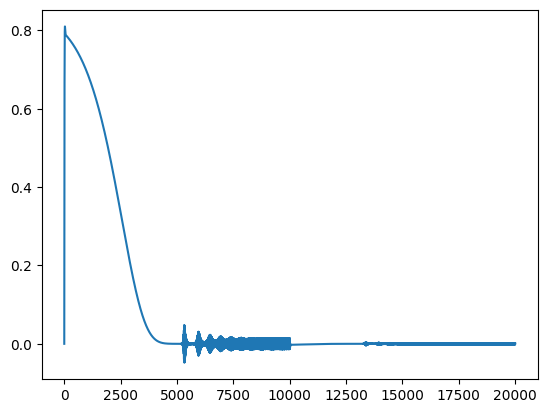

In [84]:
plt.plot(out.b_history)

In [71]:
model.compute_loss(Y,P)

6.2992653670343246e-06